# Access to private EPN-TAP data services through Jupyter notebook

In [1]:
import pyvo as vo
from matplotlib import pyplot as plt
from astropy.table import Table
import urllib

## 1- Query an EPN-TAP data service
Example from VIRTIS / Venus-Express

Here we access the service directly from its URL, not through the registry. This applies to private services.

In [3]:
service = vo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")


Query a subset of the dataset (M_VIS calibrated data before July 30, 2006) - will produce warnings

In [4]:
resultset = service.search("SELECT * FROM vvex.epn_core WHERE granule_gid = 'calibrated' AND time_max <= 2453946.50000000 AND channel_id = 'VIRTIS_M_VIS'")

In [5]:
# table of metadata for this subset 
resultset

<Table length=588>
granule_uid granule_gid   obs_id  ... science_case_id sc_pointing_mode
                                  ...                                 
   object      object     object  ...      int32           object     
----------- ----------- --------- ... --------------- ----------------
 VV0042_00C  calibrated VV0042_00 ...               7            INERT
 VV0028_00C  calibrated VV0028_00 ...               3           MOSAIC
 VV0026_04C  calibrated VV0026_04 ...               3           MOSAIC
 VV0099_06C  calibrated VV0099_06 ...               2        NADIR_POW
 VV0075_20C  calibrated VV0075_20 ...               1        NADIR_POW
 VV0075_19C  calibrated VV0075_19 ...               2        NADIR_POW
 VV0038_00C  calibrated VV0038_00 ...               2        NADIR_POW
 VV0028_07C  calibrated VV0028_07 ...               3           MOSAIC
 VV0029_01C  calibrated VV0029_01 ...               3           MOSAIC
 VV0028_04C  calibrated VV0028_04 ...               3     

In [6]:
# extract start times
timemin = (resultset['time_min'])
#timemin

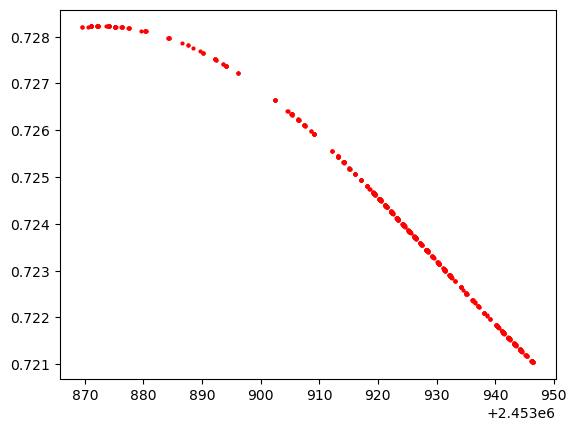

In [7]:
# plots solar distance vs time of session
sundist = (resultset['sun_distance_min'])
p=plt.plot(timemin, sundist, 'ro', ms=2)

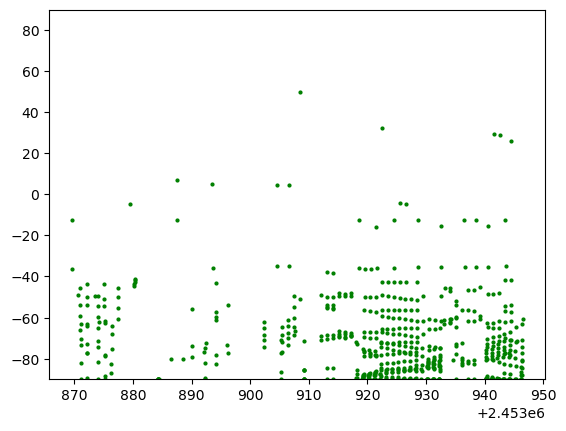

In [8]:
# plots Southernmost latitude vs time of session
lat = (resultset['c2min'])
p=plt.plot(timemin, lat, 'go', ms=2)
p= plt.ylim(-90,90)

Such plots can be used to monitor instrument or observational parameters included in the metadata table

## 2- Use TOPCAT to manipulate metadata outside of Jupyter notebook

In [10]:
# store query result locally
resultset.to_table().write(output="result.vot", format="votable", overwrite=True)

Metadata are sent to TOPCAT using the Stilts scripting language (distributed with TOPCAT)
- can be declared in Unix path, typically: set path = ($path /Applications/ApplisAstro/topcat/bin)
- (adjust to your own system - Stilts may be embded in the TOPCAT bundle on Mac)

In [12]:
# with TOPCAT open => send the table there for manipulation
!/Applications/ApplisAstro/topcat/TOPCAT.app/Contents/Resources/bin/stilts tpipe ifmt=votable in=result.vot omode=topcat

Metadata can then be plotted interactively inside TOPCAT

Stilts can also be used as an external plotting tool (no need to launch TOPCAT)

In [13]:
!/Applications/ApplisAstro/topcat/TOPCAT.app/Contents/Resources/bin/stilts plot2plane layer1=mark ifmt1=votable in1=result.vot \
 ymax=90 x1=time_min y1=c2min

Quit Stilts when you're done

## 3- Retrieve a data file

Assuming the file of interest is already identified

In [13]:
#only retrieves access_url for granule of interest

resultset = service.search("select * from vvex.epn_core where granule_uid = 'VI0025_08C'")
print(resultset.fieldnames)

('granule_uid', 'granule_gid', 'obs_id', 'dataproduct_type', 'target_name', 'target_class', 'time_min', 'time_max', 'time_sampling_step_min', 'time_sampling_step_max', 'time_exp_min', 'time_exp_max', 'spectral_range_min', 'spectral_range_max', 'spectral_sampling_step_min', 'spectral_sampling_step_max', 'spectral_resolution_min', 'spectral_resolution_max', 'c1min', 'c1max', 'c2min', 'c2max', 'c3min', 'c3max', 's_region', 'c1_resol_min', 'c1_resol_max', 'c2_resol_min', 'c2_resol_max', 'c3_resol_min', 'c3_resol_max', 'spatial_frame_type', 'incidence_min', 'incidence_max', 'emergence_min', 'emergence_max', 'phase_min', 'phase_max', 'instrument_host_name', 'instrument_name', 'measurement_type', 'processing_level', 'creation_date', 'modification_date', 'release_date', 'service_title', 'access_url', 'access_format', 'access_estsize', 'time_scale', 'thumbnail_url', 'file_name', 'publisher', 'bib_reference', 'sun_distance_min', 'sun_distance_max', 'target_distance_min', 'target_distance_max', '

In [14]:
for row in resultset:
     print(row['access_url'])

https://archives.esac.esa.int/psa/ftp/VENUS-EXPRESS/VIRTIS/VEX-V-VIRTIS-2-3-V3.0/DATA/MTP001/VIR0025/CALIBRATED/VI0025_08.CAL


This particular service provides links to files in the PSA archive

In [15]:
# no longer works?
#url = row.getdataurl()
#url
# this is OK
url = resultset['access_url', 0]
url

'https://archives.esac.esa.int/psa/ftp/VENUS-EXPRESS/VIRTIS/VEX-V-VIRTIS-2-3-V3.0/DATA/MTP001/VIR0025/CALIBRATED/VI0025_08.CAL'

In [16]:
file_name = resultset['file_name', 0]
file_name

'VI0025_08.CAL'

In [21]:
# fetch file where indicated
## urllib.request.urlretrieve(url, filename=file_name)

('VI0025_08.CAL', <http.client.HTTPMessage at 0x139a427c0>)

Wait for the file to download

## 4- Reading and plotting the data


PDS4 files are supported under python. However, VVEx files are PDS3 cubes - this type of file is more easily read 
under IDL with the python-IDL bridge installed (solutions may exist under python for PDS3)

In [17]:
import os
from idlpy import *

IDL 8.8.1 (darwin x86_64 m64).
(c) 2021, Harris Geospatial Solutions, Inc.

Licensed for use by: Observatoire de Paris
License: 35196
A new version is available: IDL 8.8.3
https://harrisgeospatial.flexnetoperations.com
 


In [18]:
filepath='/Users/serard/AnacondaProjects' 
os.chdir(filepath)

% Compiled module: ASTROLIB.
% ASTROLIB: Astronomy Library system variables have been added
% $MAIN$: Fichiers de cartographie planetaire dans !CARTES_DIR
% $MAIN$: Exemples doc dans !EX_DIR
Ajout des chemins pour les exemples
% $MAIN$: Spectres PDS dans !PDS_SLIB
% $MAIN$: Spectres dans !SPEC_DIR
% $MAIN$: Spectres planets dans !PLSPEC_LIB
% $MAIN$: Images Ceres dans !Ceres_dir
% $MAIN$: Spectres PDS dans !VEX _DIR
% $MAIN$: Rosetta local dans !ROS_DIR
  


In [19]:
# Read cube from IDL routine
IDL.run("pwd")
IDL.run("tt= virtispds(python.file_name)")

'% Loaded DLM: PYTHON39.\n% Compiled module: VIRTISPDS.\n% Compiled module: V_HEADPDS.\nReading label VI0025_08.CAL\n% Compiled module: V_PDSPAR.\n% Compiled module: V_STR2NUM.\n% Compiled module: V_READPDS.\n% Compiled module: V_GETPATH.\n% Compiled module: V_OBJPDS.\n% Compiled module: V_QUBEPDS.\n% Compiled module: V_LISTPDS.\n% Compiled module: V_TYPEPDS.\n% Compiled module: V_POINTPDS.\n% Compiled module: V_SWAPDATA.\n% Compiled module: SWAP_ENDIAN_INPLACE.\nNumber of objects found:            2\n \n% VIRTISPDS: File in use: VI0025_08.CAL\n** Structure <c7689a08>, 8 tags, length=107499480, data length=107499476, refs=1:\n   LABEL           STRING    Array[157]\n   TABLE           FLOAT     Array[432, 256, 3]\n   QUBE_NAME       STRING    Array[2]\n   QUBE_DIM        LONG      Array[3]\n   QUBE            FLOAT     Array[432, 256, 240]\n   SUF_NAME        STRING    Array[3]\n   SUF_DIM         LONG      Array[2]\n   SUFFIX          UINT      Array[3, 240]'

In [20]:
# pass it to python
IDL.run("ss= tt.qube")
tutu = IDL.ss
IDL.run("help, ss")
# retrieve wvl vector from cube file
IDL.run("wvl=tt.table[*,256/2,0]")
wvl = IDL.wvl
# cube size
tutu.shape

(240, 256, 432)

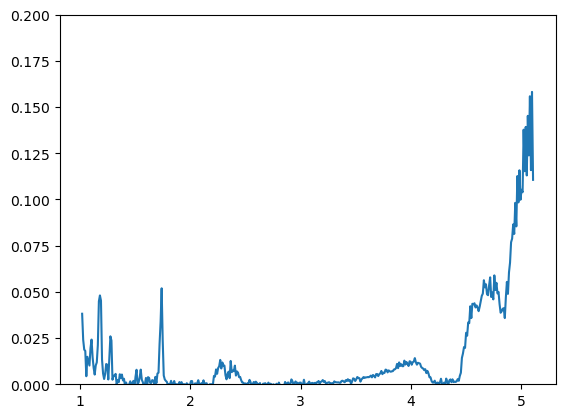

In [21]:
# Plot one IR spectrum of Venus nightside
from matplotlib import pyplot as plt
p=plt.plot(wvl,tutu[10,101,:])
p2= plt.ylim(0,0.2)
pl= plt.show()

In [22]:
# print wvl of interest for image, in micron
wvl[78]

1.7574998

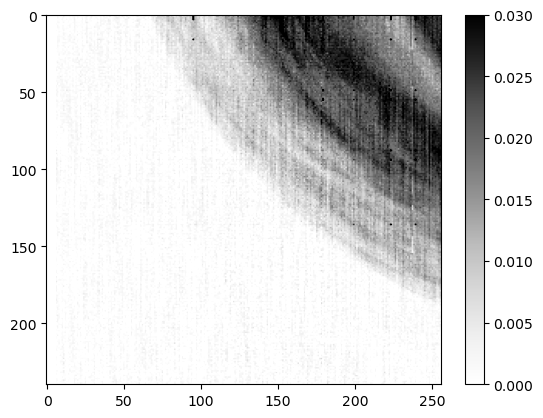

In [24]:
# Plot image of Venus nightside in O2 emission band
imgplot = plt.imshow(tutu[:, :, 78], cmap=plt.cm.Greys, vmin=0, vmax=0.03)
plt.colorbar()
plt.show()

Play as you wish